In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [2]:
force1=pd.read_csv('FlowStress_Prediction.csv')

In [3]:
force1['strain']=np.log(force1['sch_entry_thickness']/force1['sch_exit_thickness'])
force1['strain_rate']=force1['strain']*force1['meas_speed_fpm']/np.sqrt(0.5*force1['avgrolldiam']*(force1['sch_entry_thickness']-force1['sch_exit_thickness']))
force1['ln_strain']=np.log(force1['strain'])
force1['ln_strain_rate']=np.log(force1['strain_rate'])
force1['core_temp']=force1['meas_entry_temp']+5/9*0.75*force1['model_target_gauge']*(force1['meas_entry_temp']**4/308300000000+(force1['meas_entry_temp']-70)**1.25/1412)
R=8.314
force1['1/RT']=1/(R*force1['core_temp'])

In [4]:
a=force1.loc[force1['model_grade']=='02015573FN2 ']

In [5]:
a = a.dropna(subset=['1/RT'])

## ln (C1) + C2/RT +C4*ln(strain rate)

In [6]:
# Define the Zener-Hollomon flow stress curve equation
def zener_holloman(c1,c2,c4,RT,strain_rate):
    #RT = temperature * 8.314  # assuming gas constant R = 8.314 J/(mol*K)
    return c1*np.exp(c2*RT)*(strain_rate ** c4)

# Define the objective function to minimize (using mean squared error)
def objective_function(coef,RT,strain_rate,measured_values):
    predicted_values = zener_holloman(coef[0], coef[1],coef[2], RT,strain_rate)
    return np.mean((predicted_values - measured_values) ** 2)

#strain = force1['Strain']
#strain_rate = force1['Strain Rate']
RT= a['1/RT']
strain_rate = a['strain_rate']
measured_values = a['meas_flow_stress']

# Initial guess for coefficients
#initial_guess = np.array([5684853.280812844,30600.773266375065,-0.14659341280912486,0.41966654801836967])
initial_guess = [1,1,1]


#5684853.280812844
#30600.773266375065
#-0.14659341280912486
#0.41966654801836967

# Bounds for coefficients
#bounds = [(10000, 200000000), (5000, 200000), (0, 1.1), (0, 1.1)]  

# Optimize the coefficients using scipy minimize function
result = minimize(objective_function, initial_guess, args=(RT, strain_rate, measured_values),tol=1e-10)

# Extract optimized coefficients
optimized_coefs = result.x

# Print optimized coefficients
print("Optimized coefficients:", optimized_coefs)

# Compute predicted values using optimized coefficients
predicted_values = zener_holloman(optimized_coefs[0], optimized_coefs[1],optimized_coefs[2], RT,strain_rate)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(measured_values, predicted_values))
print("RMSE:", rmse)

# Compute R^2
r2 = r2_score(measured_values, predicted_values)
print("R^2:", r2)


Optimized coefficients: [5.84635127e-01 3.64310653e+04 3.01005409e-01]
RMSE: 3.431041580707567
R^2: 0.8789914468068607


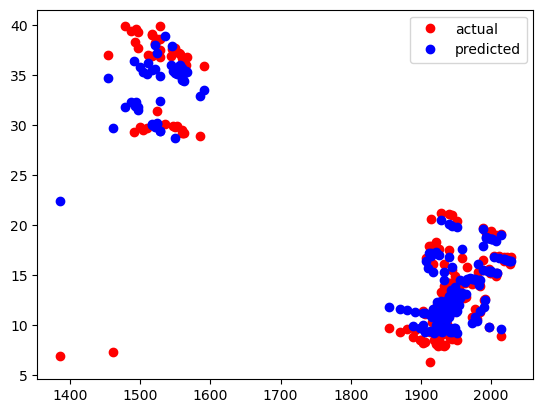

In [7]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],predicted_values,'bo',label='predicted')
plt.legend()
plt.show()

## ln (C1) + C2/RT + C3*ln(strain) + C4*ln(strain rate)

In [8]:
# Define the Zener-Hollomon flow stress curve equation
def zener_holloman(c1,c2,c3,c4,RT,strain,strain_rate):
    #RT = temperature * 8.314  # assuming gas constant R = 8.314 J/(mol*K)
    return c1*np.exp(c2*RT)*(strain** c3)*(strain_rate ** c4)

# Define the objective function to minimize (using mean squared error)
def objective_function(coef,RT,strain,strain_rate,measured_values):
    predicted_values = zener_holloman(coef[0], coef[1],coef[2],coef[3], RT,strain,strain_rate)
    return np.mean((predicted_values - measured_values) ** 2)

#strain = force1['Strain']
#strain_rate = force1['Strain Rate']
RT= a['1/RT']
strain = a['strain']
strain_rate = a['strain_rate']
measured_values = a['meas_flow_stress']

# Initial guess for coefficients
#initial_guess = np.array([5684853.280812844,30600.773266375065,-0.14659341280912486,0.41966654801836967])
initial_guess = [1,1,1,1]


#5684853.280812844
#30600.773266375065
#-0.14659341280912486
#0.41966654801836967

# Bounds for coefficients
#bounds = [(10000, 200000000), (5000, 200000), (0, 1.1), (0, 1.1)]  

# Optimize the coefficients using scipy minimize function
result = minimize(objective_function, initial_guess, args=(RT, strain,strain_rate, measured_values),tol=1e-10)

# Extract optimized coefficients
optimized_coefs = result.x

# Print optimized coefficients
print("Optimized coefficients:", optimized_coefs)

# Compute predicted values using optimized coefficients
predicted_values = zener_holloman(optimized_coefs[0], optimized_coefs[1],optimized_coefs[2],optimized_coefs[3], RT,strain,strain_rate)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(measured_values, predicted_values))
print("RMSE:", rmse)

# Compute R^2
r2 = r2_score(measured_values, predicted_values)
print("R^2:", r2)

Optimized coefficients: [ 5.90164031e-01  1.40052581e+04 -4.63096547e-01  5.08906152e-01]
RMSE: 2.749292672386919
R^2: 0.9223026771440436


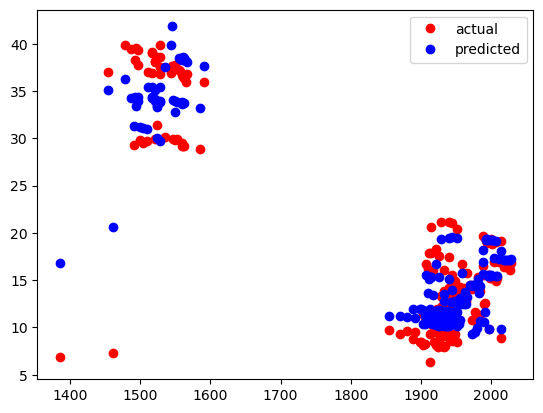

In [9]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],predicted_values,'bo',label='predicted')
plt.legend()
plt.show()

## Optimization with Polyfit degree 3

In [10]:
gas_temp=a['1/RT']
X = np.column_stack([
    np.ones_like(gas_temp),
    gas_temp,
    a['ln_strain'],
    a['ln_strain_rate']
])


In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Assuming you have your data in RT_data, strain_data, strain_rate_data, and y_data

# Combine the features into one array
#X_data = np.column_stack((RT_data, strain_data, strain_rate_data))

# Define polynomial regression model
degree = 6  # Choose the degree of the polynomial, 2 or 4 deteriorate the answer
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model to the data
model.fit(X,measured_values)

# Predict using the model
y_pred = model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(measured_values, y_pred)
print("Mean Squared Error:", mse)

# Print coefficients if needed
coefficients = model.named_steps['linearregression'].coef_
print("Coefficients:", coefficients)
print("Intercept:",model.named_steps['linearregression'].intercept_)
print("R^2:",metrics.r2_score(measured_values, y_pred))

Mean Squared Error: 0.2771286607236563
Coefficients: [ 4.56755146e+08 -4.64049100e+08 -1.82011398e+08  6.01503098e+08
 -2.35604948e+09 -1.42394729e+08 -1.40189851e+09 -1.81152879e+08
  4.05657873e+08  3.17724659e+09 -2.88375590e+09  8.10185006e+08
  4.40017226e+06  1.30555494e+08  1.12677671e+07  1.45547316e+08
 -1.27653007e+09 -1.05178946e+08  4.87697671e+08  2.97935339e+09
 -2.88282428e+09  7.04839880e+08 -1.18536198e+06 -3.25238727e+07
 -2.87275560e+06  4.65061663e+05 -6.73341872e+09  1.91289938e+09
 -2.37702074e+09  2.11480599e+09 -7.62898173e+07 -4.54998720e+04
  7.93490291e+04 -4.88344491e+04  1.38621087e+04  9.14388782e-01
 -1.27652869e+09 -1.05180541e+08  4.87701106e+08  2.97935299e+09
 -2.88282445e+09  7.04839545e+08 -1.18793699e+06 -3.25233481e+07
 -2.87126892e+06  4.65345291e+05 -6.73341873e+09  1.91289945e+09
 -2.37702124e+09  2.11480586e+09 -7.62895499e+07 -4.67248727e+04
  7.93475019e+04 -4.88343767e+04  1.38605192e+04  4.39453764e+01
 -9.50757254e+05  2.88940777e+05  1.0

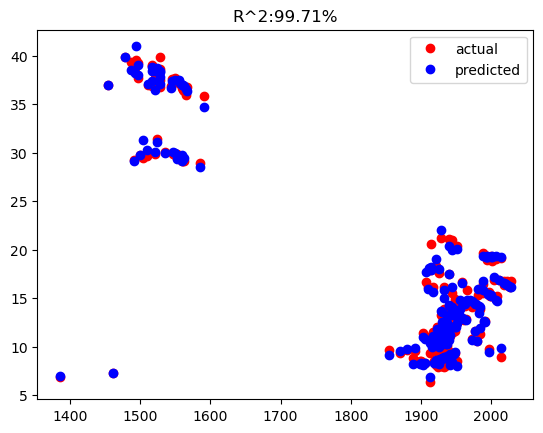

In [12]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],y_pred,'bo',label='predicted')
plt.title('R^2:99.71%')
plt.savefig('02015573FN2.jpg')
plt.legend()
plt.show()

In [13]:
print(len(coefficients))

210


### Intercept for C1, and the first three coefficients for RT, strain, strain\_rate

In [14]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree, include_bias=False)
model = LinearRegression()

# Apply polynomial transformation
X_poly = poly.fit_transform(X)

# Fit the model to the polynomial features
model.fit(X_poly, measured_values)


# The model is now trained with polynomial features. Coefficients relate directly to the transformed features.
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:",intercept)
print("R^2:",metrics.r2_score(measured_values, y_pred))

Coefficients: [ 3.58903886e+07  1.49853391e+07 -6.86824429e+06  4.02287290e+06
  6.09425369e+06  2.34543340e+07  9.84226086e+06  1.20597614e+07
 -4.30750018e+11 -1.40163904e+05  2.16325065e+06 -1.93964180e+07
  2.23413769e+07 -7.41133663e+07  4.55574002e+06  1.30310262e+07
 -2.97332946e+06 -1.60831886e+07 -4.30749419e+11 -2.79209567e+06
  1.76210426e+06  1.93965685e+07 -2.23415528e+07  7.41134449e+07
 -5.96498179e+07 -2.20743208e+11  1.38893191e+11 -4.05582683e+06
  5.84724856e+06 -1.94423123e+06 -7.98443142e+00  3.12505946e+01
 -2.02482939e+01  2.24897300e+00]
Intercept: -46540559.34562483
R^2: 0.997151307653181


### The reason for 35 coefficients

35 coefficients are generated because we are using polynomial features up to the third degree with three original features (RT, strain, and strain_rate). Each combination of these features up to the third degree results in a polynomial feature. Here's the breakdown:

1. Constant term (intercept): 1 coefficient
2. Linear terms (3 features): 3 coefficients
3. Quadratic terms (3 features): 3 coefficients
4. Cross-terms (3 * 3 = 9 combinations): 9 coefficients
5. Cubic terms (3 features): 3 coefficients
6. Mixed terms (3 * 3 * 2 = 18 combinations): 18 coefficients

Total coefficients: 1 + 3 + 3 + 9 + 3 + 18 = 37

However, one coefficient is the intercept term, so the total number of coefficients related to the features (RT, strain, and strain_rate) is 37 - 1 = 36.

Here's how they are associated:

- 1 coefficient for the constant term (intercept)
- 3 coefficients for the linear terms (RT, strain, strain_rate)
- 3 coefficients for the quadratic terms (RT^2, strain^2, strain_rate^2)
- 9 coefficients for the cross-terms (RT * strain, RT * strain_rate, strain * strain_rate)
- 3 coefficients for the cubic terms (RT^3, strain^3, strain_rate^3)
- 18 coefficients for the mixed terms (RT^2 * strain, RT^2 * strain_rate, strain^2 * RT, strain^2 * strain_rate, strain_rate^2 * RT, strain_rate^2 * strain)

These coefficients represent the weights assigned to each corresponding feature in the polynomial regression model.